In [19]:
import pandas as pd
import scanpy as sc
import os
import torch
import anndata
import numpy as np
from torchmetrics import R2Score
import matplotlib.pyplot as plt

import seaborn as sns
directory = os.path.join(os.getcwd(), 'pred0')

In [2]:
def compute_r2(y_true, y_pred):
    """
    Computes the r2 score for `y_true` and `y_pred`,
    returns `-1` when `y_pred` contains nan values
    """
    y_pred = torch.clamp(y_pred, -3e12, 3e12)
    metric = R2Score().to(y_true.device)
    metric.update(y_pred, y_true)  # same as sklearn.r2_score(y_true, y_pred)
    return metric.compute().item()

In [3]:
ood_conds=['CNN1+ETS2',
 'FOXF1',
 'EKLF',
 'UBASH3A',
 'CNN1',
 'FOXA1',
 'BAK1',
 'CEBPE',
 'SET',
 'RUNX1',
 'ETS2',
 'SLC4A1',
 'MEIS1',
 'MIDEAS',
 'OSR2',
 'CEBPE+RUNX1',
 'TBX2+TBX3',
 'CBARP',
 'UBASH3B',
 'DUSP9+ETS2',
 'MAP2K6',
 'OSR2+UBASH3B']

In [4]:
ccl='K562'

In [5]:
mean_score=[]
var_score=[]

for a in ood_conds:
    yp_m=pd.read_pickle(f'{directory}/means_pred_{ccl}_{a}.pkl').values.mean(0)   
    yp_v=pd.read_pickle(f'{directory}/var_pred_{ccl}_{a}.pkl').values.mean(0)
    y_true=pd.read_pickle(f'{directory}/ytrue_pred_{ccl}_{a}.pkl').values
    yt_m = y_true.mean(0)
    yt_v = y_true.var(0)
    
    
    r2_m = compute_r2(torch.tensor(yt_m), torch.tensor(yp_m))
    r2_v = compute_r2(torch.tensor(yt_v), torch.tensor(yp_v))
    
    mean_score.append(max(r2_m, 0.0))
    var_score.append(max(r2_v, 0.0))

<Axes: ylabel='Count'>

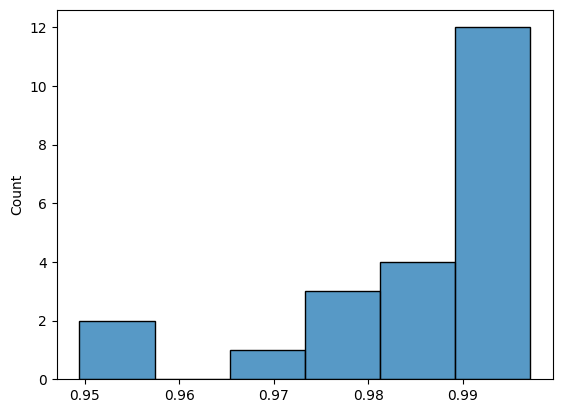

In [6]:
sns.histplot(mean_score)

<Axes: ylabel='Count'>

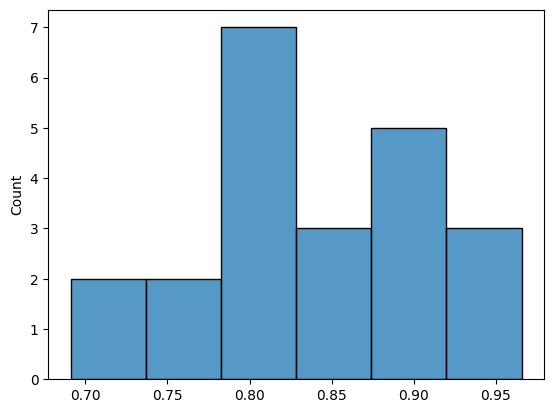

In [7]:
sns.histplot(var_score)

In [8]:
pd.DataFrame({'c':ood_conds, 'sc':mean_score}).sort_values('sc')

c        sc
7          CEBPE  0.949453
8            SET  0.952777
16     TBX2+TBX3  0.971176
14          OSR2  0.975396
15   CEBPE+RUNX1  0.976409
10          ETS2  0.980657
11        SLC4A1  0.981762
2           EKLF  0.983120
19    DUSP9+ETS2  0.986312
4           CNN1  0.988155
21  OSR2+UBASH3B  0.989699
20        MAP2K6  0.991024
13        MIDEAS  0.993164
0      CNN1+ETS2  0.993621
9          RUNX1  0.993800
1          FOXF1  0.994694
5          FOXA1  0.994859
6           BAK1  0.995107
12         MEIS1  0.996678
17         CBARP  0.996747
18       UBASH3B  0.997129
3        UBASH3A  0.997167

In [20]:
mean_score=[]
var_score=[]

for a in ood_conds:
    yp_m=np.array(a0[a0.obs['treatment']=='control'].X).mean(0)   
    yp_v=np.array(a0[a0.obs['treatment']=='control'].X).var(0)  
    y_true=pd.read_pickle(f'{directory}/ytrue_pred_{ccl}_{a}.pkl').values
    yt_m = y_true.mean(0)
    yt_v = y_true.var(0)
    
    
    r2_m = compute_r2(torch.tensor(yt_m), torch.tensor(yp_m))
    r2_v = compute_r2(torch.tensor(yt_v), torch.tensor(yp_v))
    
    mean_score.append(max(r2_m, 0.0))
    var_score.append(max(r2_v, 0.0))

<Axes: ylabel='Count'>

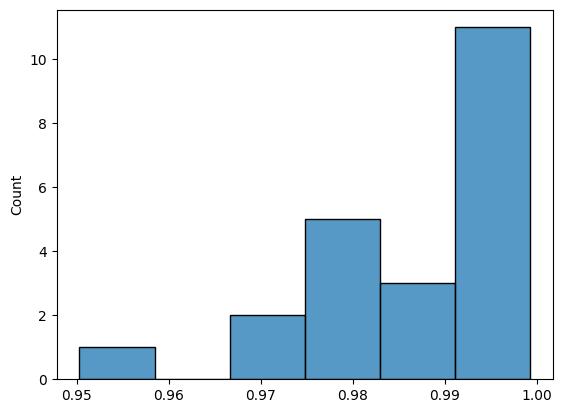

In [21]:
sns.histplot(mean_score)

<Axes: ylabel='Count'>

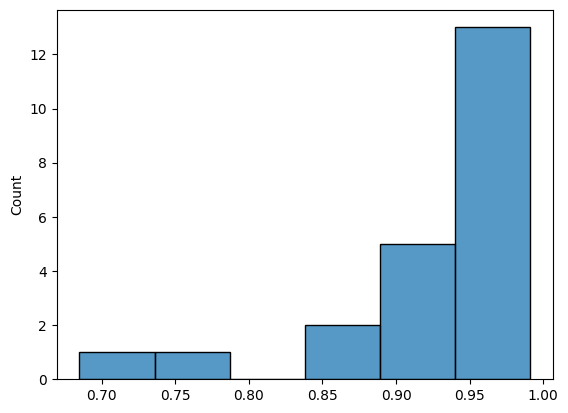

In [22]:
sns.histplot(var_score)

In [23]:
Path='/home/manu/chemCPA/chemCPA/anndatas'
a0=sc.read_h5ad(f'{Path}/adata_empty.h5ad')

/home/manu/bl/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [24]:
a='CEBPE'
# perturbation data - predicted
yp_m=pd.read_pickle(f'{directory}/means_pred_{ccl}_{a}.pkl').values 
yp_v=pd.read_pickle(f'{directory}/var_pred_{ccl}_{a}.pkl').values
X=yp_m+np.random.normal(0,1,yp_m.shape)*yp_v
a2=anndata.AnnData(X)
a2.obs['set']='pertubed_predicted'
a2.obs['treatment']=a

In [25]:
adata=anndata.concat([a0,a2])
adata.obs['reduced_treatments']=[a if a in ['control', 'CEBPE'] else 'not' for a in adata.obs['treatment']]
adata

/home/manu/bl/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 99694 × 2000
    obs: 'set', 'treatment', 'reduced_treatments'

### And some UMAPS

In [26]:
sc.pp.pca(adata)

In [27]:
plt.rcParams['figure.dpi'] = 300

/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


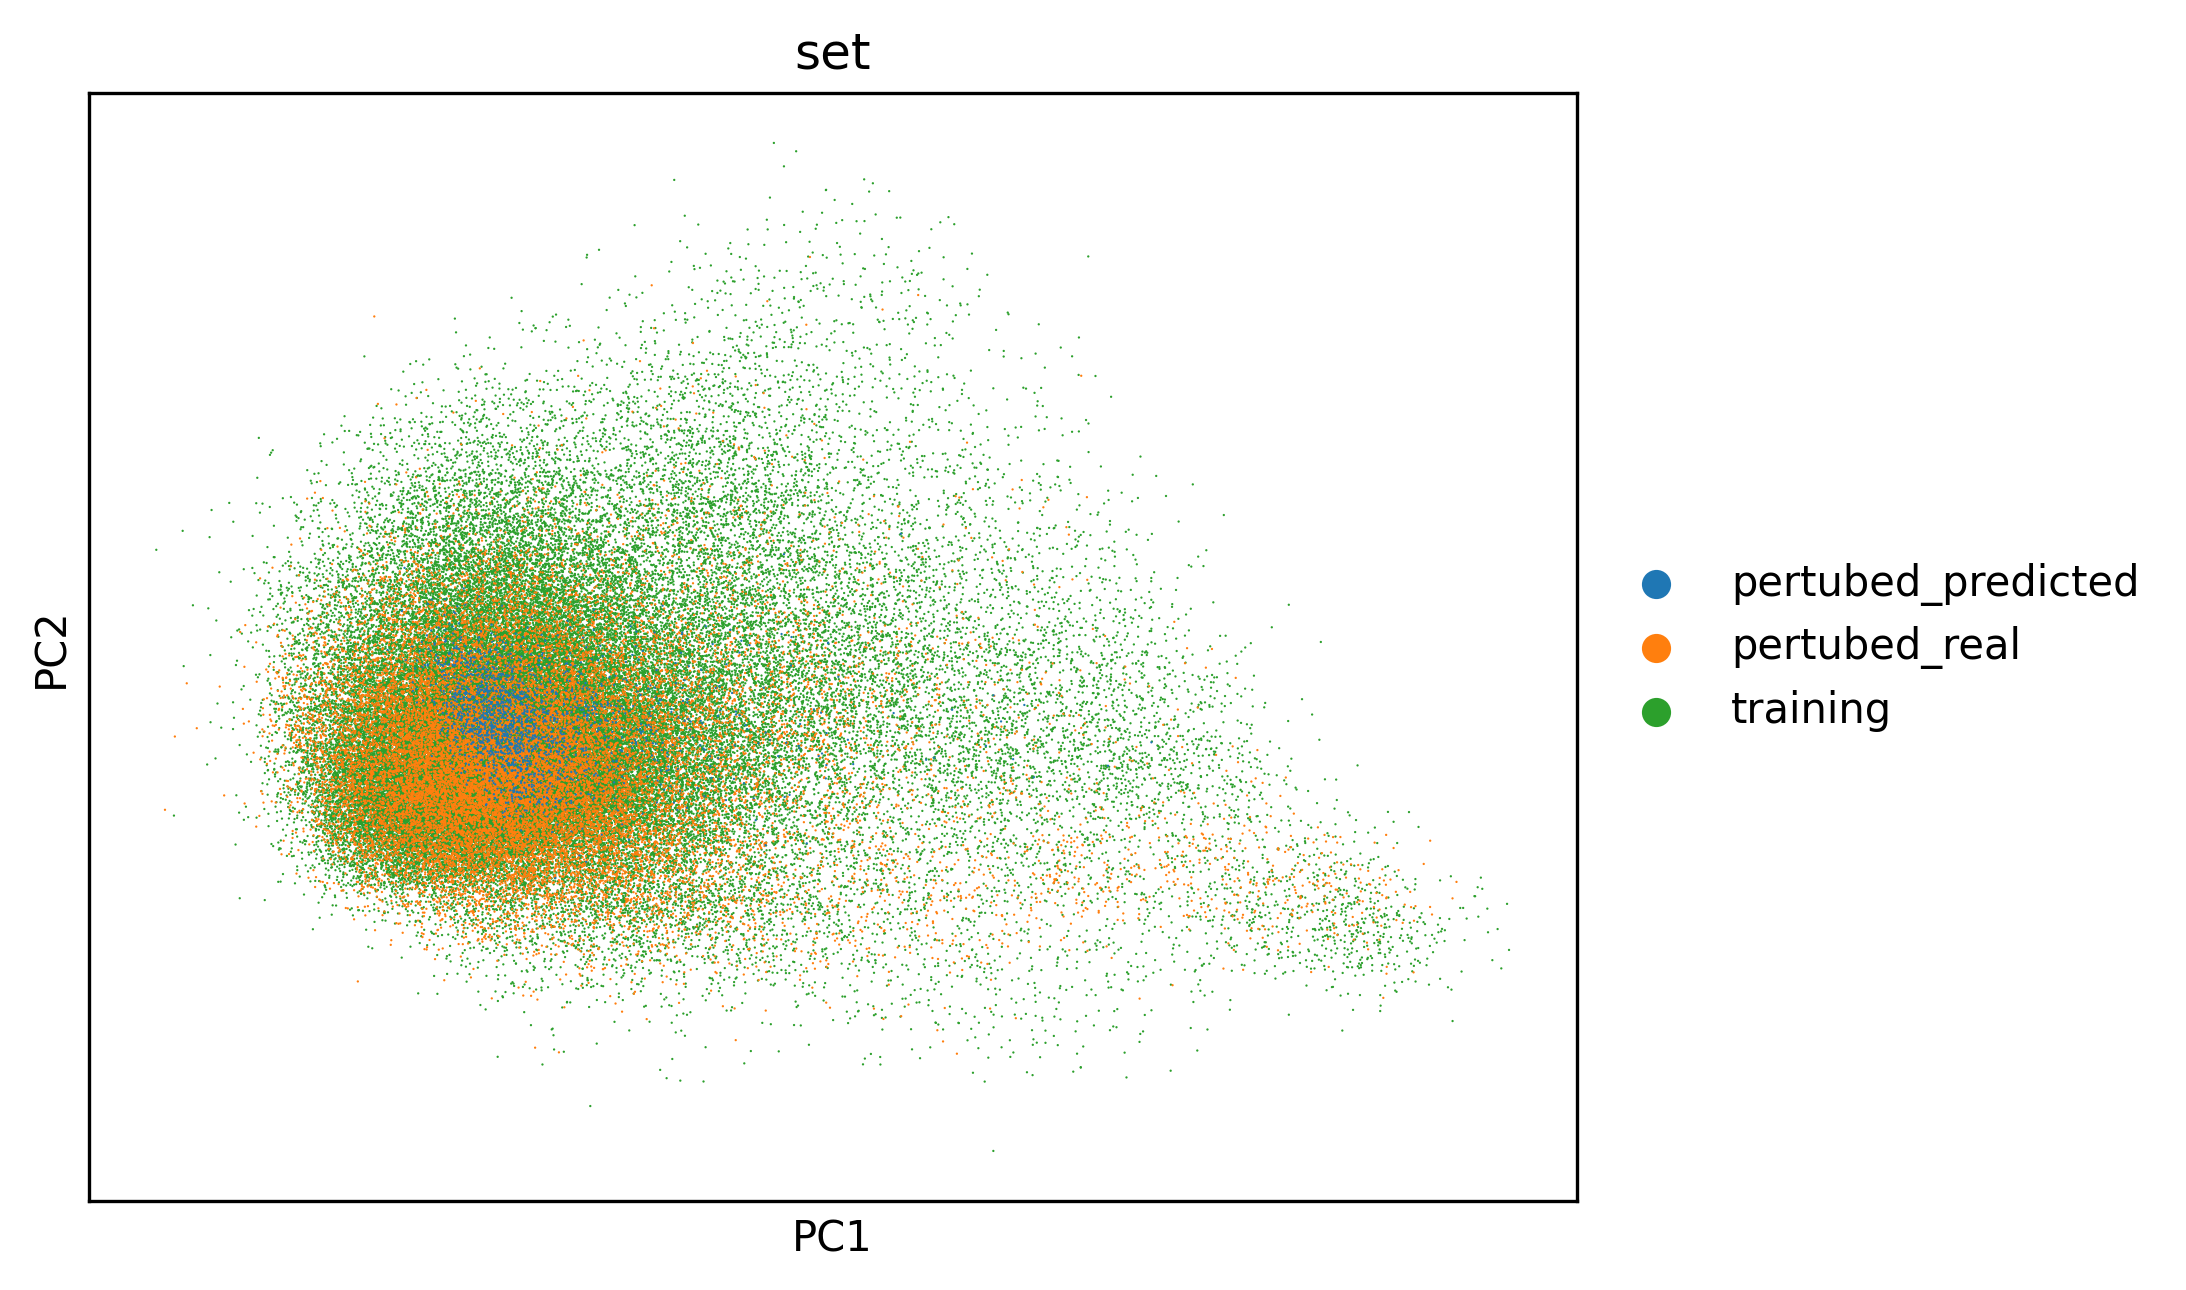

In [28]:
sc.pl.pca(adata, color='set')

/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


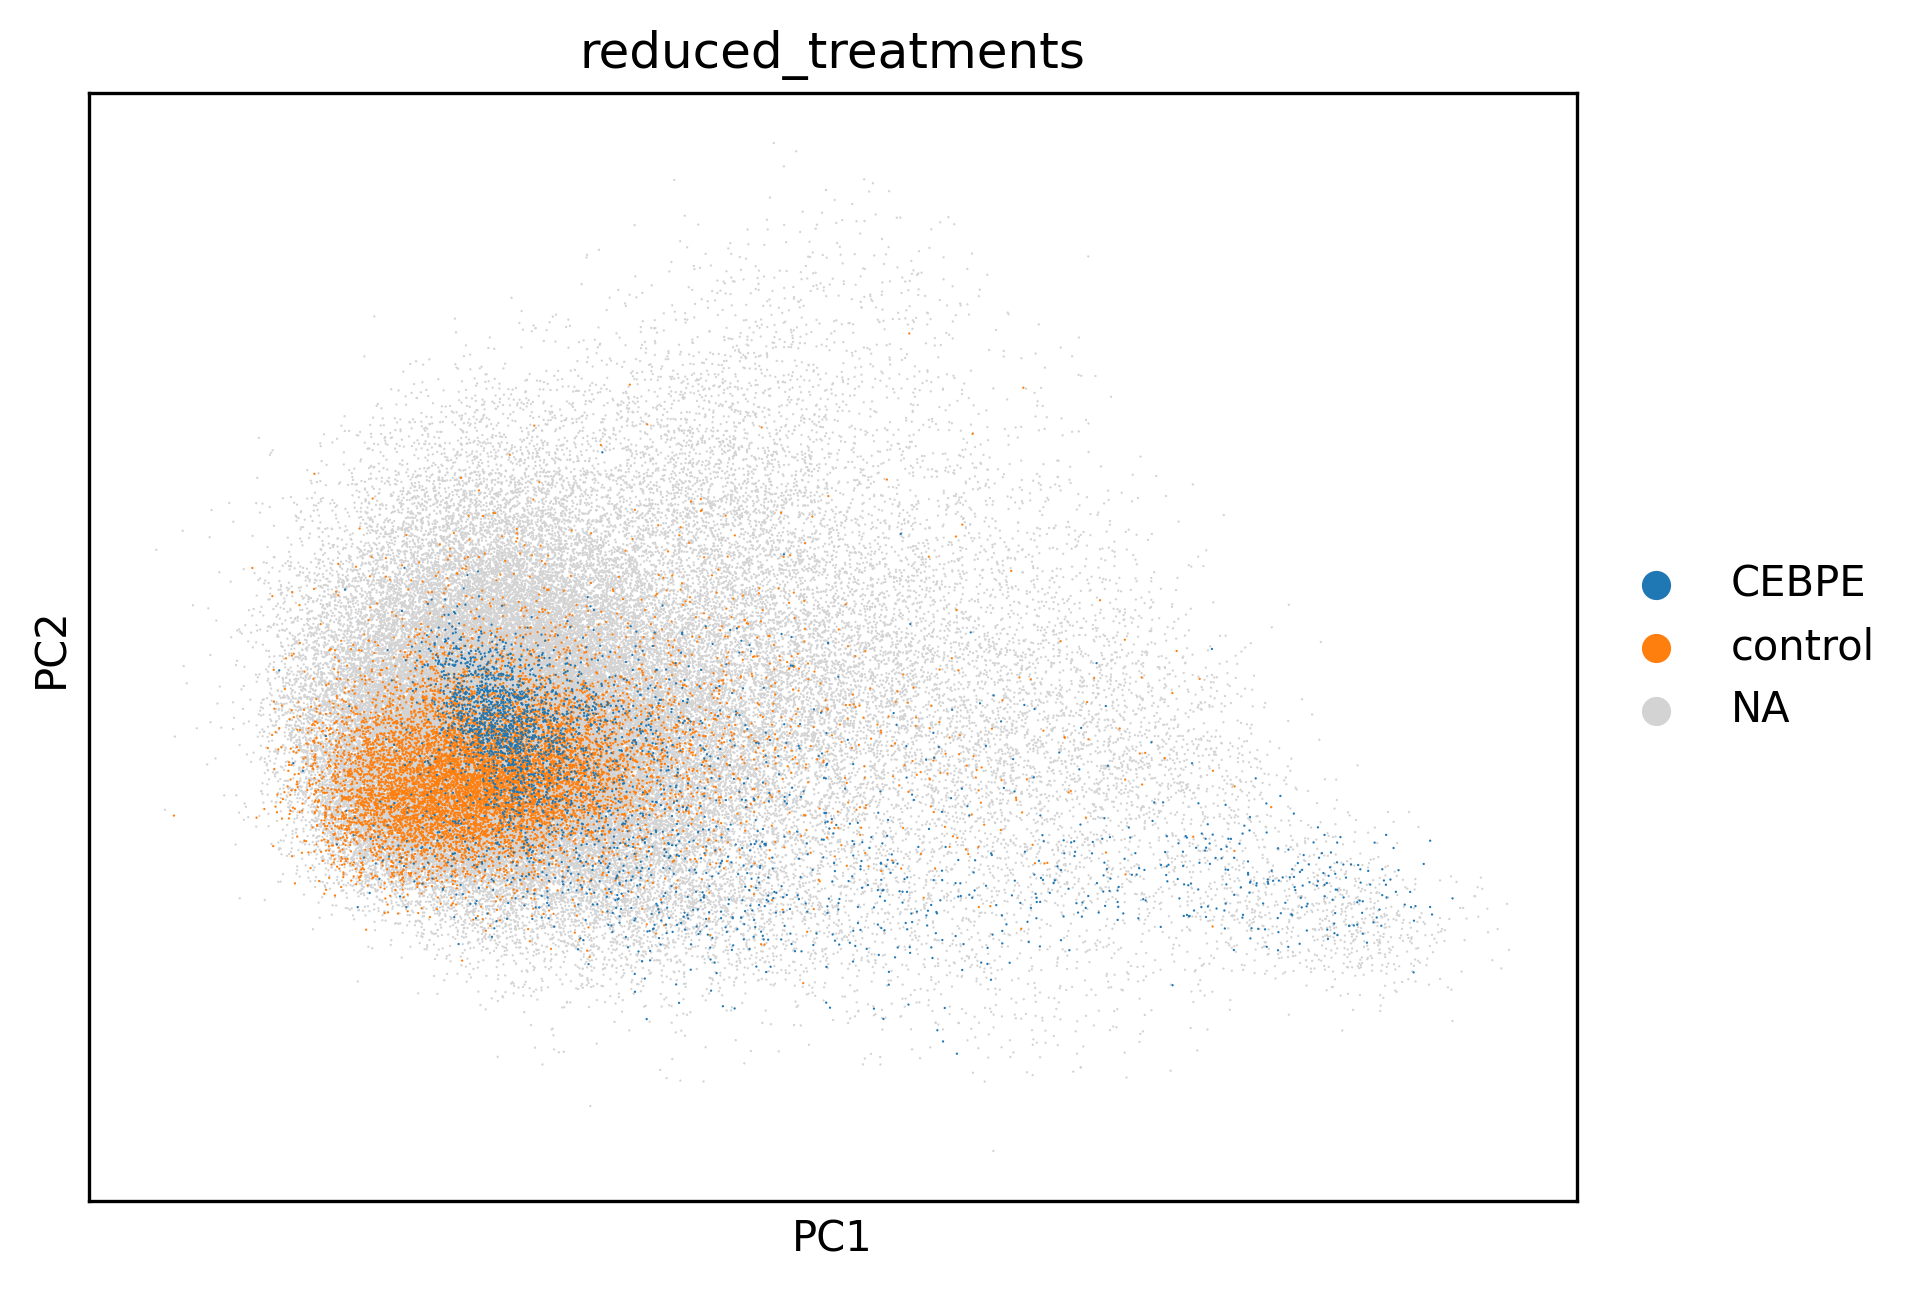

In [29]:
sc.pl.pca(adata, color='reduced_treatments', groups=['control', 'CEBPE'])

In [30]:
sc.pp.neighbors(adata)

/home/manu/bl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
sc.tl.umap(adata, random_state=3)

/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


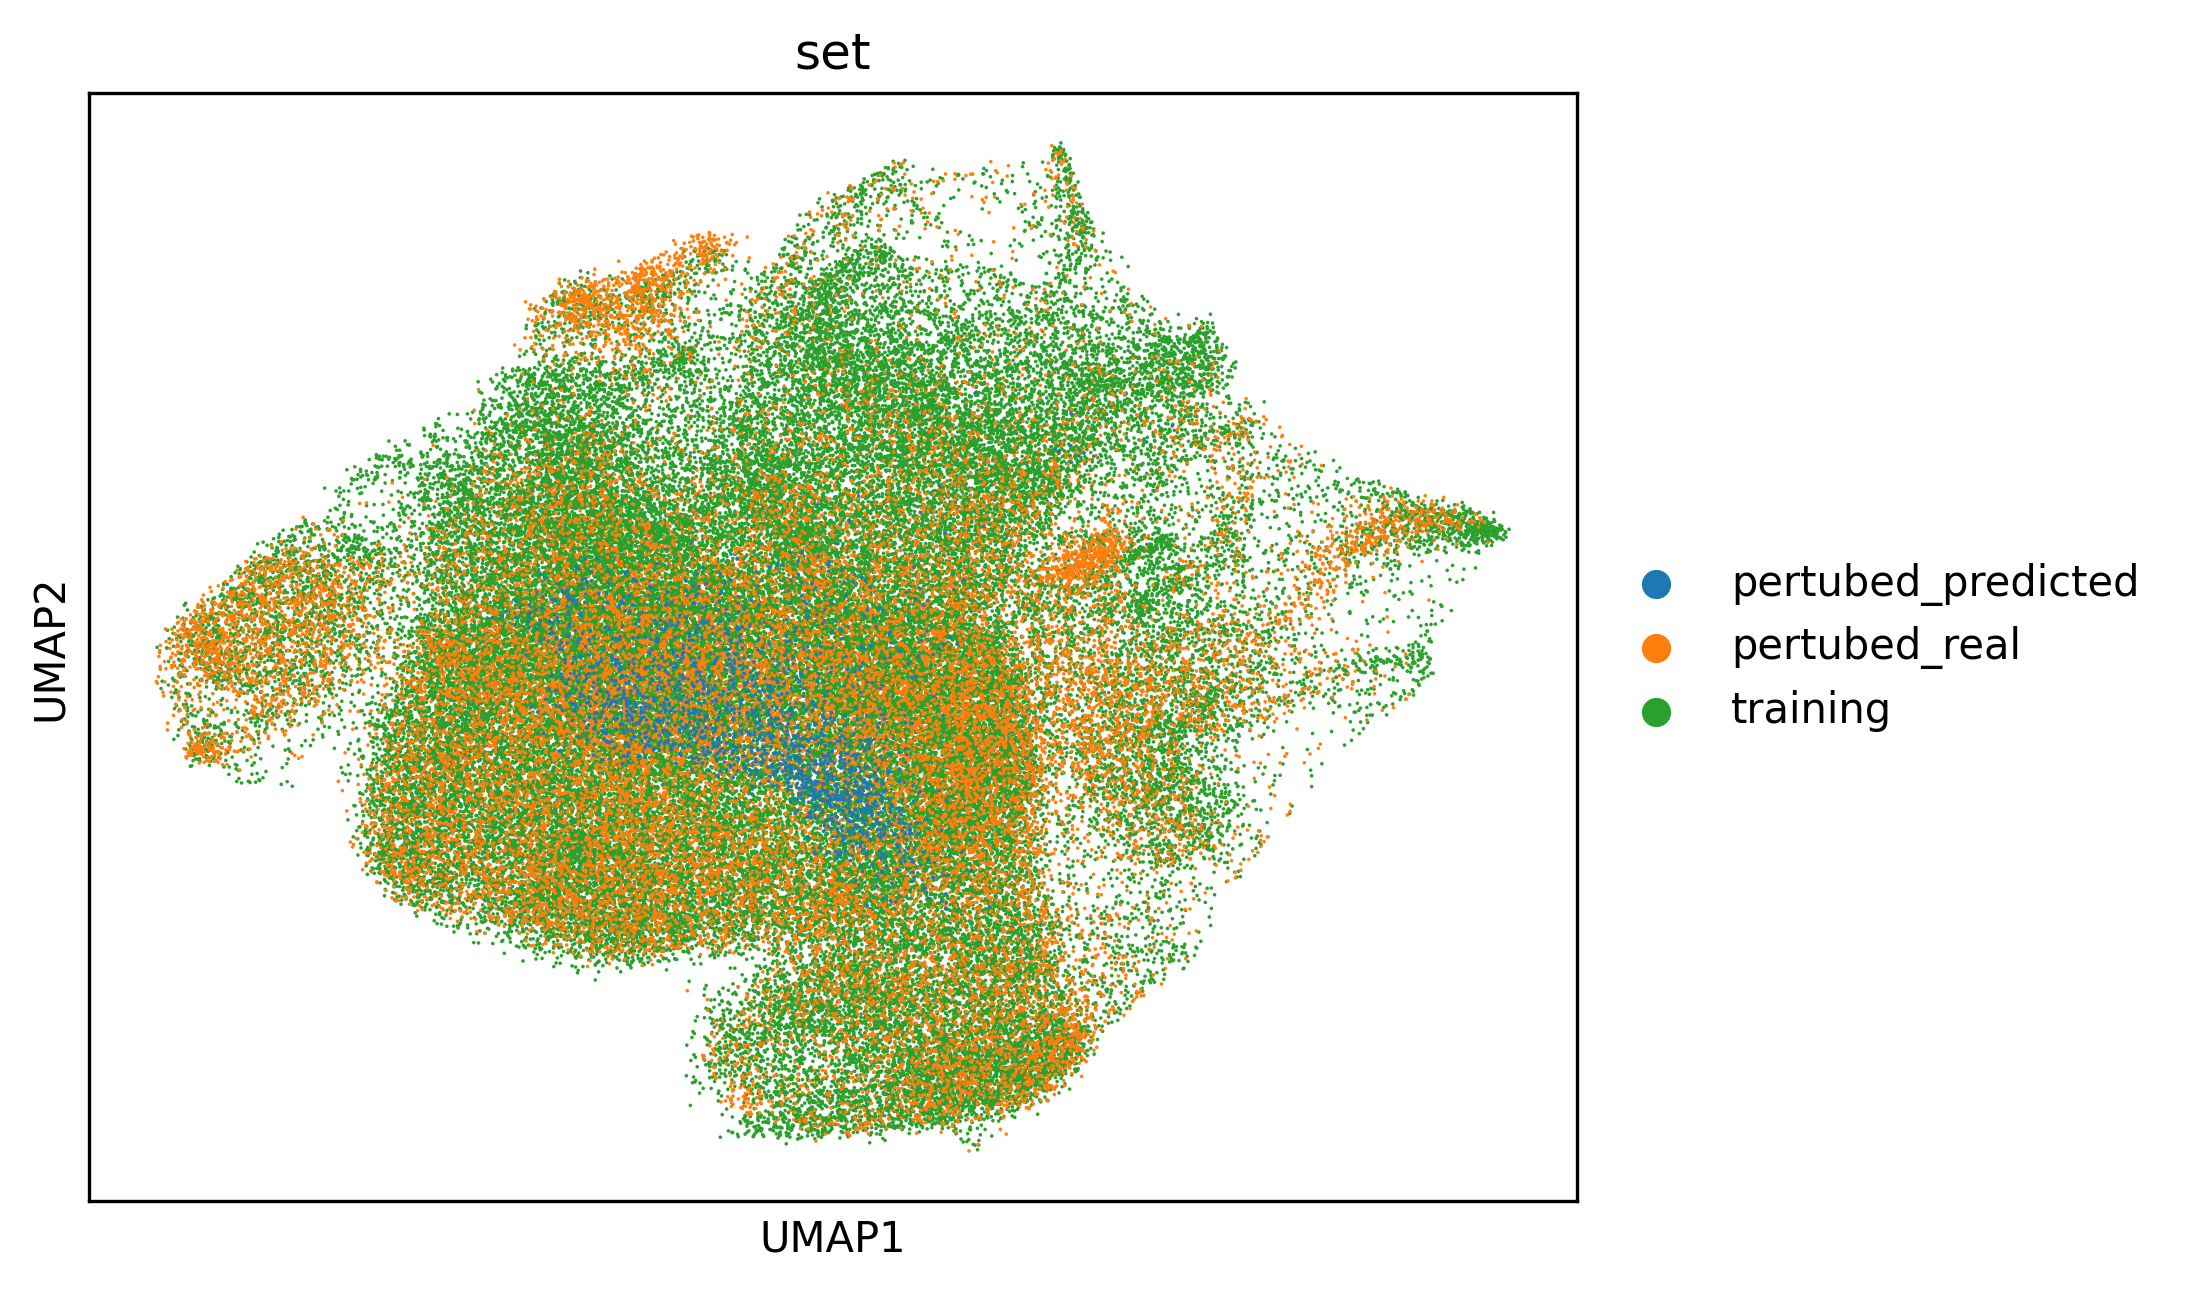

In [41]:
sc.pl.umap(adata, color='set', s=3)

In [42]:
adata.obs['set_and_treatment']=adata.obs['set'].astype('str')+'_'+adata.obs['reduced_treatments'].astype('str')
adata.obs['set_and_treatment'].value_counts()

set_and_treatment
training_not                65431
pertubed_real_not           21198
training_control            10072
pertubed_predicted_CEBPE     1763
pertubed_real_CEBPE          1230
Name: count, dtype: int64

/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


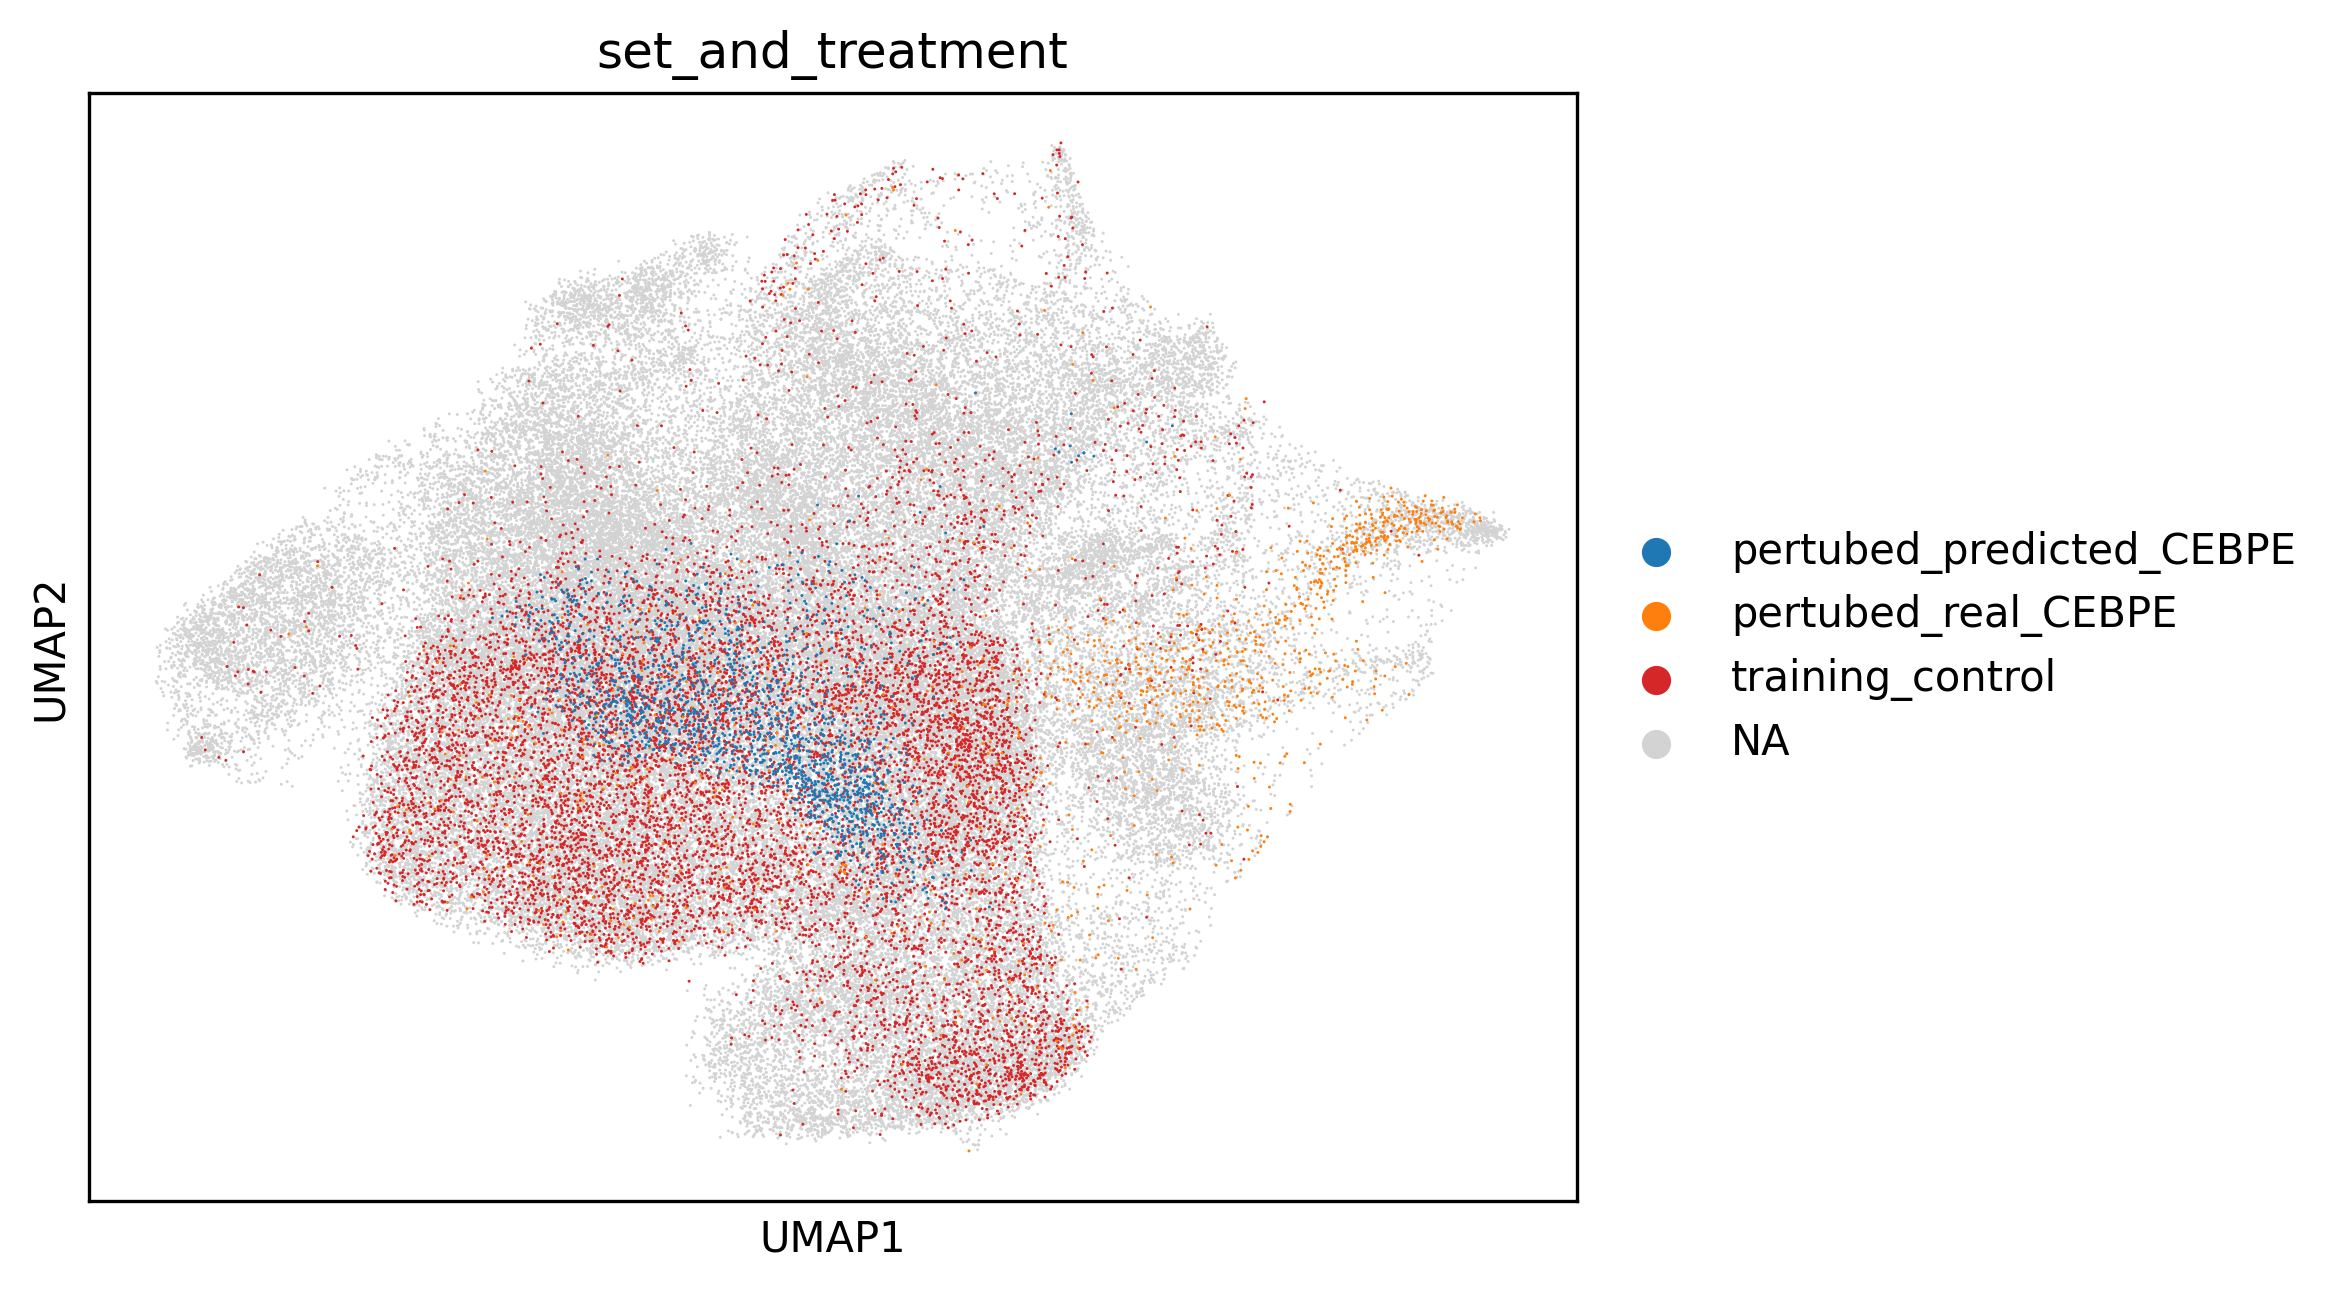

In [46]:
sc.pl.umap(adata, color='set_and_treatment', groups=['training_control', 'pertubed_predicted_CEBPE', 'pertubed_real_CEBPE'], s=2)